In [1]:
import torch.nn as nn
import torch
from Seq2SeqModel.Seq2SeqModel import Seq2SeqModel
import pandas as pd
from transformers import AutoTokenizer
import torch.nn.init as init

# CSV 파일에서 데이터 불러오기
df_train = pd.read_csv("Datatset/train.csv")
df_val = pd.read_csv("Datatset/val.csv")
tokenizer= AutoTokenizer.from_pretrained("Datatset/tokenizer")

def str_to_list(input_string):
    cleaned_string = input_string.strip("[]").replace(" ", "")

    number_strings = cleaned_string.split(",")
    number_list = [int(num) for num in number_strings]
    return number_list

# 데이터 추출
X_train = df_train["X_train"].values.tolist()
X_train=[str_to_list(i) for i in X_train]
y_train = df_train["y_train"].values.tolist()
y_train=[str_to_list(i) for i in y_train]


X_val = df_val["X_val"].values.tolist()
X_val=[str_to_list(i) for i in X_val]
y_val = df_val["y_val"].values.tolist()
y_val=[str_to_list(i) for i in y_val]




In [2]:
newx=[]
newy=[]
for x,y in zip(X_train,y_train):
    if len(x)<20 and len(y)<20:
        newx.append(x)
        newy.append(y)

In [3]:
X_train=[]
for i in newx:
    i=tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(i))
    X_train.append(i)

In [4]:
y_train=[]
for i in newy:
    i=tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(i))
    y_train.append(i)

In [5]:
print(X_train[10],y_train[10],len(X_train))

<bos> Credit Card▁Tracker</s> <bos> Traqueur de carte de créditName</s> 152122


In [6]:
newx1=[]
newy1=[]
for x,y in zip(X_val,y_val):
    if len(x)<20 and len(y)<20:
        newx1.append(x)
        newy1.append(y)

In [7]:
X_val=[]
for i in newx1:
    i=tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(i))
    X_val.append(i)

In [8]:
y_val=[]
for i in newy1:
    i=tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(i))
    y_val.append(i)

In [16]:
from transformers import AutoTokenizer

# 토크나이저 선택
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({"bos_token": "<bos>"})

# 트레이닝 데이터와 라벨 데이터 (예시 데이터)
training_data = X_train+X_val+y_train+y_val
# 텍스트 데이터 전처리 및 토큰화
tokenized_data = tokenizer(training_data, padding=True, truncation=True, return_tensors="pt")



In [21]:
len(tokenizer.get_vocab())

30523

In [15]:
print(newx1[1])
print(X_train[1])
tokenizer.convert_ids_to_tokens(newx1[1])


[59514, 17921, 3317, 12812, 2559, 0]
<bos> *. ui *. UI_BAR_User Interface▁Files</s>


[None, 'moreno', 'castle', 'agony', 'looking', '[PAD]']

In [19]:

import pandas as pd
df_train = pd.DataFrame({
    "X_train": newx,
    "y_train": newy,
})

df_val = pd.DataFrame({
    "X_val": newx1,
    "y_val": newy1,
})

tokenizer.save_pretrained("Datatset3/tokenizer")

df_train.to_csv("Datatset3/train.csv",index=False)
df_val.to_csv("Datatset3/val.csv",index=False)


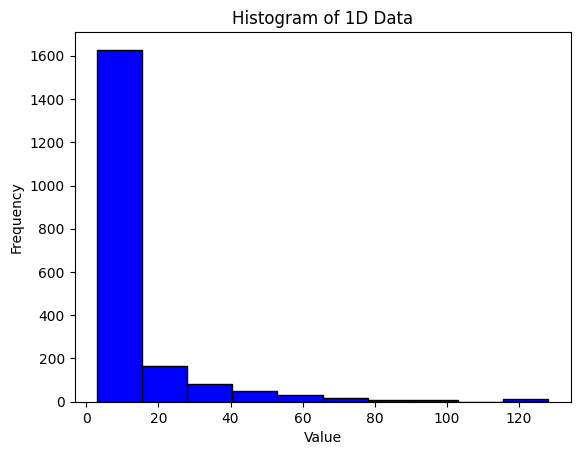

In [16]:
import matplotlib.pyplot as plt

# 1차원 리스트 데이터 (예시 데이터)

# 히스토그램 그리기
plt.hist(x, bins=10, color='blue', edgecolor='black')

# 그래프 제목 및 레이블 설정
plt.title('Histogram of 1D Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 히스토그램 출력
plt.show()


## 1

In [2]:
device = torch.device('cpu')

tokenizer= AutoTokenizer.from_pretrained("Datatset/tokenizer")
model=None
class_weights = torch.ones(tokenizer.vocab_size+1).to(device=device)
class_weights[tokenizer.pad_token_id]=0.1
class_weights[tokenizer.pad_token_id-1]=0.1
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.01,weight=class_weights)
optimizer=None
batchsize=64
lr=0.005
print("Set")
module=Seq2SeqModel( tokenizer,loss_fn, lr,
                    X_train,y_train,X_val,y_val,
                     batch_size=batchsize, device=torch.device("cpu"), n_layer=8,n_head=4)
print(module.config.n_dec_seq)


Set
Using cpu
128


In [3]:

print("train")
module.load_model("saved2.pth")

train


In [4]:
print(module.config)

{'n_enc_vocab': 59515, 'n_dec_vocab': 59515, 'n_enc_seq': 128, 'n_dec_seq': 128, 'n_layer': 8, 'd_hidn': 128, 'i_pad': 59513, 'd_ff': 256, 'n_head': 4, 'd_head': 128, 'dropout': 0.2, 'layer_norm_epsilon': 1e-12}


In [14]:
tokenizer.get_vocab()["/"]

74

## i_pad 수정후


In [5]:
from tqdm import tqdm
import random

def evaluate(module): #easy eva
    epT=enumerate(module.val_data_loader)
    for i, (x1, x2, yy) in epT:
        if module.device:
            x1=x1.to(module.device)
            x2=x2.to(module.device)
            yy=yy.to(module.device)

        module.model.eval()
        predict,*attentions=module.model(x1,x2)
        return attentions #enc_att,dec_att,enc_dec_atts

In [6]:
def att_mean_std(id,att,show=True):
    attlist_for_head=[i for i in att[id].view(att[id].size(1),att[id].size(2),-1)]
    if show:
        print("======="*10+"\n"+"======="*10)
        print(f"{id} 번째 att분포 ")
        for i in attlist_for_head:
            data_mean = torch.mean(i,dim=1)[:5]
            data_std = torch.std(i,dim=1)[:5]
            data_max=torch.max(i,dim=1)[0][:5]
            data_max_id=torch.max(i,dim=1)[1][:5]
            data_sum=torch.sum(i,dim=1)[:5]
            pad_att=i[20:,:]
            print(f"    mean: {data_mean}\n     std: {data_std},\n     data_max: {data_max},\n     max_id: {data_max_id}\n     sum: {data_sum}\n----------")

    return attlist_for_head,pad_att

In [7]:
att=evaluate(module=module)
print("Dec_encAtt")
a,b=att_mean_std(-1,att[-1])
a=0
# for i in range(-1,module.config.n_layer*-1-1,-1):
#     att_mean_std(i,att[1])#dec_enc

Dec_encAtt
-1 번째 att분포 
    mean: tensor([0.0078, 0.0078, 0.0078, 0.0078, 0.0078], grad_fn=<SliceBackward0>)
     std: tensor([0.0354, 0.0354, 0.0354, 0.0354, 0.0354], grad_fn=<SliceBackward0>),
     data_max: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667], grad_fn=<SliceBackward0>),
     max_id: tensor([2, 5, 2, 2, 5])
     sum: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SliceBackward0>)
----------
    mean: tensor([0.0078, 0.0078, 0.0078, 0.0078, 0.0078], grad_fn=<SliceBackward0>)
     std: tensor([0.0354, 0.0354, 0.0354, 0.0354, 0.0354], grad_fn=<SliceBackward0>),
     data_max: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667], grad_fn=<SliceBackward0>),
     max_id: tensor([4, 1, 0, 0, 1])
     sum: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SliceBackward0>)
----------
    mean: tensor([0.0078, 0.0078, 0.0078, 0.0078, 0.0078], grad_fn=<SliceBackward0>)
     std: tensor([0.0354, 0.0354, 0.0354, 0.0354, 0.0354], grad_fn=<SliceBackward0>),
     data_max: 

In [8]:
epT=enumerate(module.val_data_loader)
for i, (x1, x2, yy) in epT:
    if module.device:
        x1=x1.to(module.device)
        x2=x2.to(module.device)
        yy=yy.to(module.device)
    module.model.eval()
    predict,*attentions=module.model(x1,x2)
    predict=predict.view(-1,predict.size(2))
    print(predict.shape)
    data_mean = torch.mean(predict,dim=1)[:5]
    data_std = torch.std(predict,dim=1)[:5]
    data_max=torch.max(predict,dim=1)
    data_max_id=torch.max(predict,dim=1)[1][:5]
    data_sum=torch.sum(predict,dim=1)[:5]
    pad_att=predict[-5:,tokenizer.pad_token_id]
    print(f"    mean: {data_mean}\n     std: {data_std},\n     data_max: {data_max[0][:5]},\n     max_id: {data_max_id}\n     sum: {data_sum}\n----------")
    print(pad_att)
    break
    

torch.Size([127, 59515])
    mean: tensor([1.6802e-05, 1.6802e-05, 1.6802e-05, 1.6802e-05, 1.6802e-05],
       grad_fn=<SliceBackward0>)
     std: tensor([0.0041, 0.0041, 0.0041, 0.0041, 0.0041], grad_fn=<SliceBackward0>),
     data_max: tensor([1., 1., 1., 1., 1.], grad_fn=<SliceBackward0>),
     max_id: tensor([38492, 38492, 38492, 38492, 38492])
     sum: tensor([1., 1., 1., 1., 1.], grad_fn=<SliceBackward0>)
----------
tensor([0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)


In [9]:
print(data_max)

torch.return_types.max(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.], grad_fn=<MaxBackward0>),
indices=tensor([38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
        38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
        38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
        38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
        38492, 38492, 38492, 38492, 38492, 38492, 3

In [10]:
print(predict)
predict=torch.max(predict,dim=1)[1]
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(predict)))

tensor([[1.7704e-41, 2.4432e-40, 4.3431e-39,  ..., 2.6098e-38, 0.0000e+00,
         3.5746e-37],
        [1.7704e-41, 2.4433e-40, 4.3432e-39,  ..., 2.6099e-38, 0.0000e+00,
         3.5747e-37],
        [1.7704e-41, 2.4433e-40, 4.3432e-39,  ..., 2.6098e-38, 0.0000e+00,
         3.5746e-37],
        ...,
        [1.7704e-41, 2.4433e-40, 4.3432e-39,  ..., 2.6098e-38, 0.0000e+00,
         3.5747e-37],
        [1.7704e-41, 2.4433e-40, 4.3432e-39,  ..., 2.6098e-38, 0.0000e+00,
         3.5747e-37],
        [1.7704e-41, 2.4433e-40, 4.3432e-39,  ..., 2.6098e-38, 0.0000e+00,
         3.5747e-37]], grad_fn=<ViewBackward0>)
#160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #160;: #

## predict


In [11]:
dd=6
print(type(y_train[dd]),type(X_train[dd]))
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(y_train[dd])))

a,*b=module.seq_to_seq_process(X_train[dd],y_train[dd])

<class 'list'> <class 'list'>
<bos> Anubis, ou Inpou & #160; / Anepou, était un dieu égyptien de la vie de l'au-delà. Pour récupérer le trésor entre les oreilles d'Anubis, creusez les deux colonnes à la gauche de la momie et marchez sur le haut de la momie. Déplacez vous à gauche de la momie en creusant vers la droite. La momie devrait tomber dans le trou dans la colonne la plus à droite. Maintenant creusez les deux colonnes de gauche jusqu'à ce que vous vous connectez à l 'œ il-échelle. Descendez de</s>
seq_padd:  128
seq_padd:  128
seq_padd:  127
<bos> Anubis, or Inpu,▁was an▁Egyptian▁god of the▁afterlife. To▁get the▁treasure▁between Anubis'▁ears,▁dig▁out the▁two▁columns to the▁left of the▁mummy and stand on top of the▁mummy.▁Move▁left off the▁mummy▁while▁digging▁right. The▁mummy▁should▁fall▁into the▁hole in the▁right▁most▁column.▁Now▁dig▁out the▁left▁two▁columns▁until you▁connect to the▁ladder-eye.▁Move▁down from the▁right▁most▁ladder of the▁eye and you will▁fall to the▁pole▁below. 

In [12]:
print(a)
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(a.view(-1))))
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(b[0])))
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(b[1])))

tensor([[38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492, 38492,
         38492, 38492, 38492, 38492, 38492, 38492, 3